In [66]:
from keras import backend as K
from vis.backprop_modifiers import get
from vis.input_modifiers import Jitter
from vis.losses import Loss
from vis.regularizers import LPNorm, TotalVariation

from models.VLAE import VLAE

In [2]:
model = VLAE(input_dim=(28,28,1), log_dir="tralala", kernel_visualization_layer=1, num_samples=1, feature_map_layers=[1], inner_activation="ReLU", decay_rate=0.3, feature_map_reduction_factor=2, z_dims=[2,2,2], dropout_rate=0.3)

In [3]:
model.load_weights("/Users/leo/Documents/Tesla/alexnet-vae-no-padding/logs_vlae_mnist_smaller_model_20-03-2020/weights/weights.h5")

In [212]:
class MyActivationMaximization(Loss):
    """A loss function that maximizes the activation of a set of filters within a particular layer.
    Typically this loss is used to ask the reverse question - What kind of input image would increase the networks
    confidence, for say, dog class. This helps determine what the network might be internalizing as being the 'dog'
    image space.
    One might also use this to generate an input image that maximizes both 'dog' and 'human' outputs on the final
    `keras.layers.Dense` layer.
    """
    def __init__(self, layers, desired_mean = (0.0, 0.0)):
        """
        Args:
            layer: The keras layer whose filters need to be maximized. This can either be a convolutional layer
                or a dense layer.
            filter_indices: filter indices within the layer to be maximized.
                For `keras.layers.Dense` layer, `filter_idx` is interpreted as the output index.
                If you are optimizing final `keras.layers.Dense` layer to maximize class output, you tend to get
                better results with 'linear' activation as opposed to 'softmax'. This is because 'softmax'
                output can be maximized by minimizing scores for other classes.
        """
        super(MyActivationMaximization, self).__init__()
        self.desired_mean = desired_mean
        self.name = "ActivationMax Loss"
        self.layers = layers

    def build_loss(self):

        # For all other layers it is 4
        #is_dense = K.ndim(layer_output) == 2

        loss = 0.
        
        mu_layers = [l for l in self.layers if "mu" in l.name]
        log_var_layers = [l for l in self.layers if "log_var" in l.name]
        
        for lvl in log_var_layers:
            loss += K.mean(K.square(lvl.output-1.0))
            
        for ml in mu_layers:
            loss += K.mean(K.square(ml.output))
        
        return loss
    

In [213]:
def my_visualize_activation(model, layer_idx, filter_indices=None, wrt_tensor=None,
                         seed_input=None, input_range=(0, 255),
                         backprop_modifier=None, grad_modifier=None,
                         act_max_weight=1, lp_norm_weight=10, tv_weight=10, desired_mean=0.0,
                         **optimizer_params):
    if backprop_modifier is not None:
        modifier_fn = get(backprop_modifier)
        model = modifier_fn(model)

    losses = [
        (MyActivationMaximization(model.layers, desired_mean), act_max_weight),
        (LPNorm(model.input), lp_norm_weight),
        (TotalVariation(model.input), tv_weight)
    ]

    # Add grad_filter to optimizer_params.
    optimizer_params = utils.add_defaults_to_kwargs({
        'grad_modifier': grad_modifier
    }, **optimizer_params)
    

    return visualize_activation_with_losses(model.input, losses, wrt_tensor,
                                            seed_input, input_range, **optimizer_params)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 13, 13, 32)   544         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 13, 13, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 13, 13, 32)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

(-0.5, 27.5, 27.5, -0.5)

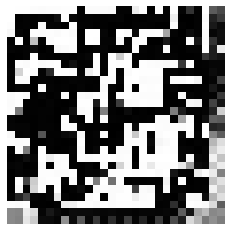

In [215]:
from vis.utils import utils
from vis.visualization import visualize_activation_with_losses
from matplotlib import pyplot as plt
model.encoder.summary()
img = my_visualize_activation(model.encoder, desired_mean=0., layer_idx=35, max_iter=500, verbose=True,
                                  lp_norm_weight=0, tv_weight=0, input_range=[0.,1.], input_modifiers=[Jitter(10)])

plt.imshow(img.squeeze(), cmap='gray')
plt.axis('off')